# Homework 3
Classification of species using SVM

In [1]:
import pandas as pd
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
%matplotlib inline

## Analysis of the dataset

We first import the well know dataset. 

In [2]:
df = pd.read_csv("IRIS_Training.csv", sep=";")
df['species'] = df['species'].astype("category")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


We can see that this dataset contains features of flowers. We check the information fo the data set to see if we have null values.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   sepal_length  90 non-null     float64 
 1   sepal_width   90 non-null     float64 
 2   petal_length  90 non-null     float64 
 3   petal_width   90 non-null     float64 
 4   species       90 non-null     category
dtypes: category(1), float64(4)
memory usage: 3.1 KB


As we see (RangeIndex) we have 90 rows and each column has 90 non-null values so we have a clean data set.

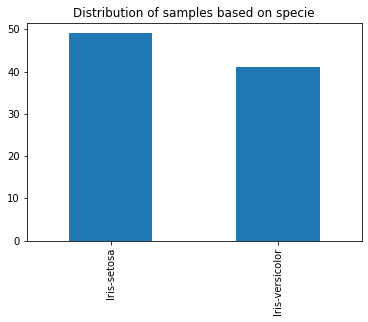

In [4]:
df['species'].value_counts().plot(kind='bar', grid=False, title="Distribution of samples based on specie")
plt.show()

In [5]:
df.groupby("species").size()

species
Iris-setosa        49
Iris-versicolor    41
dtype: int64

We see that we have 49 samples of Iris-setosa and 41 of Iris-versicolor.

Now that we know the data set we can start the task, first we need to extract the train data, that is all the features of our flowers (all the columns of the data frame except the `species` one).

In [6]:
X_train = df[df.columns[:-1]]
X = X_train.to_numpy(dtype="float32")
X.shape

(90, 4)

As we can see 90 flowers to train each one with 4 features.

In [7]:
outcome = df[df.columns[-1]]
Y_train = outcome == "Iris-setosa"
Y_train = Y_train.astype("int")
Y_train[Y_train==0] = -1
Y = np.array(Y_train)

Now we have an array `X` with shape (90,4) containing the features of the 90 flowers and an array `Y` with shape (90,1) full of 1 if the corresponding flower is Iris-setosa, and -1 if the flower is Iris-versicolor.

## Solution
As seen in class the goal of this homework is to classify two types of flowers. To do so we have to find a hyperplane that divide the space in two regions, one for the _Iris-setosa_ and the other for the _Iris-versicolor_. To do so we have to sole the following optimization problem:

$$
\text{minimize} \;\;\; \|\omega\|_2
$$
$$
\text{s.t.}\;\;\; y_i(\omega^\top x_i+b)\geq 1,
$$

where $\omega$ is the normal vector to the hyperplane, $b$ is the coordinate at the origin, $x_i$ is a vector in $\mathbb{R}^4$ containing the characteristics of one flower and $y_i$ is either 1 or -1, depending on the type of flower. The problem is completely equivalent to 

$$
\text{minimize} \;\;\; \frac{1}{2}\|\omega\|_2^2
$$
$$
\text{s.t.}\;\;\; 1-y_i(\omega^\top x_i+b)\leq 0,
$$

because $\|\omega\|_2$ and $\|\omega\|^2_2$ share the point where they achieve the minimum. This is a problem that we know how to solve because using a barrier method we can convert it into an unconstrained problem. We are going to use the logarithmic barrier and the problem becomes

$$
\text{minimize} \;\;\; f(\omega,b) = \frac{1}{2}\|\omega\|_2^2 - \left(\frac{1}{t}\right)\sum_{i=1}^n \log\left[y_i(\omega^\top x_i+b) -1\right],
$$

where $n$ is the number of samples, in our case 90. Now our problem with inequality constraints has become one without any constraint, and we have to minimize this function with respect to the parameters $\omega\in\mathbb{R}^4$ and $b\in\mathbb{R}$. To do so we implement two methods:
1. Gradient descend,
2. Newton method.

For both methods we need to compute the gradient of our function. In our case the gradient is $\nabla\to\left(\nabla_\omega,\partial_b\right)$

$$
\nabla_\omega f(\omega,b) = \omega - \left(\frac{1}{t}\right)\sum_{i=1}^n \frac{y_ix_i}{y_i(\omega^\top x_i+b) -1}
$$
$$
\partial_b f(\omega,b) = - \left(\frac{1}{t}\right)\sum_{i=1}^n \frac{y_i}{y_i(\omega^\top x_i+b) -1}. 
$$
As we can see $\nabla_\omega f(\omega,b)$ is a vector because of the factor $x_i$ in the numerator, and $\partial_b f(\omega,b)$ is a scalar because $y_i$ is a scalar. 

For the Newton method we also need the Hessian matrix so based on the book Convex Optimization by Stephen Boyd and Lieven Vandenberghe we see that the Hessian of our the logarithmic barrier has two terms.
$$
 \nabla^2 \phi(x) =\sum_{i=1}^m \frac{1}{f_i(x)^2} \nabla f_i(x) \nabla f_i(x)^T+\sum_{i=1}^m \frac{1}{-f_i(x)} \nabla^2 f_i(x),
$$

but in our case the variable is $x = (\omega,b)$ and our function $-f_i(\omega,b) = y_i(\omega^\top x_i+b) -1$. First we compute the gradient of $f_i(\omega,b)$.

$$
\nabla f_i(\omega,b) = (\nabla_\omega, \partial_b)f_i = (y_i x_i, y_i),
$$
that is a vector in this case of size $5\times 1$. To compute the second part of the Hessian we need to calculate the Hessian of $f_i$, but note that the gradient we have computed above doesn't depend on any of the variables $(\omega,b)$ so the Hessian is 0. The final form of the Hessian matrix is:
$$
\nabla^2 f(\omega,b) = \mathbb{I} - \left(\frac{1}{t}\right) \sum_{i=1}^n \frac{1}{\left[y_i(\omega^\top x_i+b) -1\right]^2}\begin{pmatrix} y_i x_i \\ y_i \end{pmatrix} \begin{pmatrix} y_i x_i & y_i \end{pmatrix}.
$$




## Code
First we define a function to compute the value $f(\omega,b)$, then the gradient of that function and lastly, the Hessian.
All this functions are vectorized in order to avoid loops.


In [8]:
def f(point, mu, y_vector, X):
    """The function to minimize. To compute the value of the function
    we define some matrices to avoid for loops.

    Args:
        point: is an array in which the first element is b
            and the rest are vector w.
        mu: the parameter that multiplies the logarithmic barrier,
            1/t in the formula.
        y_vector: is the array containing all the values of y_i.
        X: is the matrix with all the samples features, note that
            the shape of this array is (4,90) so is the transpose of the
            one we get from the dataframe.
    """
    assert point.shape == (5,), "Incorrect size of point. The size must be 5"

    b = point[0]
    w = point[1:]
    n = X.shape[1]

    # We create some matrices to compute the function f without explicit summations
    one = np.ones(shape=(n,))
    w_matrix = np.tile(w, (n, 1)).T  # Is a matrix whose columns are the vector w
    b_vector = np.full_like(y_vector, fill_value=b)

    return 0.5 * w.T @ w - mu * one.T @ np.log(
        y_vector * ((w_matrix * X).sum(0) + b_vector) - one
    )  #       this is equivalent to np.diag(W.T.dot(X))


def gradient(point, mu, y_vector, X):
    """The gradient of the function to minimize. We create it in two parts
    first the gradient with respect to omega, and second the partial
    derivative with respect to b. To compute both we define some matrices so
    we don't have to use loops and the program runs faster.

    Args:
        point: is an array in which the first element is b
            and the rest are vector w.
        mu: the parameter that multiplies the logarithmic barrier,
            1/t in the formula.
        y_vector: is the array containing all the values of y_i.
        X: is the matrix with all the samples features, note that
            the shape of this array is (4,90) so is the transpose of the
            one we get from the dataframe.
    """
    b = point[0]
    w = point[1:]
    n = X.shape[1]

    # We create some matrices to compute the function f without explicit summations
    one = np.ones(shape=(n,))
    w_matrix = np.tile(w, (n, 1)).T  # Is a matrix whose columns are the vector w
    b_vector = np.full_like(y_vector, fill_value=b)
    denom = y_vector * ((w_matrix * X).sum(0) + b_vector) - one

    grad_w = w - mu * np.sum((y_vector * X) / denom, axis=1)
    grad_b = -mu * np.sum(y_vector / denom)
    return np.concatenate((grad_w, grad_b), axis=None)


def hessian(point, mu, y_vector, X):
    """The function that returns the Hessian of our function.
    We define some matrices to achieve a vectorized code and for
    efficiency.

    Args:
        point (_type_): is an array in which the first element is b
            and the rest are vector w.
        mu (_type_): the parameter that multiplies the logarithmic barrier,
            1/t in the formula.
        y_vector (_type_): is the array containing all the values of y_i.
        X (_type_): is the matrix with all the samples features, note that
            the shape of this array is (4,90) so is the transpose of the
            one we get from the dataframe.
    """
    b = point[0]
    w = point[1:]
    n = X.shape[1]

    # We create some matrices to compute the function f without explicit summations
    one = np.ones(shape=(n,))
    w_matrix = np.tile(w, (n, 1)).T  # Is a matrix whose columns are the vector w
    b_vector = np.full_like(y_vector, fill_value=b)
    denom = y_vector * ((w_matrix * X).sum(0) + b_vector) - one

    # First part of the hessian of the barrier
    full_grad = np.vstack((y_vector * X, y_vector))  # Each column is (\nabla f_i)

    # Create a 3d array where each slice is a matrix corresponding to one term
    # of the summation, we then sum the components of each slice to get the total
    # value of summation
    total = (
        np.einsum("ij,ik->ijk", full_grad.T, full_grad.T) / (denom[:, None, None] ** 2)
    )
    hess_1 = total.sum(axis=0)

    # Second part of the Hessian of the barrier is 0

    return np.identity(hess_1.shape[0]) - mu * hess_1

Now we define the two methods that we are going to use. First the gradient descend and second the Newton method

In [9]:
def gradient_descend(x, mu, y_vector, X):
    """The gradient descend method"""
    grad = gradient(x, mu, y_vector, X)
    
    for _ in range(10_000):
        descend_direction = -grad
        t = 0.0001
        x = x + t * descend_direction
        grad = gradient(x, mu, y_vector, X)

    return x

def newtons_method(x, mu, y_vector, X):
    """Implementation of the newton method"""

    grad = gradient(x, mu, y_vector, X)

    for _ in range(1000):
        descend_direction = npl.solve(-hessian(x, mu, y_vector, X), grad)
        t = 0.0001
        x = x + t * descend_direction
        grad = gradient(x, mu, y_vector, X)

    return x

To get our starting feasible point we choose two elements of the data set, one for the Iris-setosa and another from the Iris-versicolor. The easiest way of doing this is to take the first element $p$ and last element $q$ of the data set. As a starting vector we take the vector from one point to the other, $p-q$ and as a starting $b$, because we have the initial vector $\omega$ we need to solve a typical problem: having the normal vector of a plane, find the equation of the plane that past through the point $r$. In our case this point $r$ is the middle point between $p$ and $q$.

In [10]:
p = X[0]
q = X[-1]

w_0 = p - q
x_feasible = (p + q)/2
b = - w_0.T@x_feasible
# In code the vector is (b,\omega) in stead of (\omega,b) as in the theory
point_0 = np.append(b, w_0)

With this initial point we can apply the two methods and predict the output of the classification data set. We first define a function that will tell us which flowers are present in the training set.

In [11]:
df_test = pd.read_csv("IRIS_classification.csv", sep=";")
X_test = df_test.to_numpy()

def classify(point, X):
    """This function classify a data set into two classes

    Args:
        point: _description_
        X: the data to classify. It must have the same number
            of rows as the length of w, in this case 4.
    """
    w = point[1:]
    assert len(w) == X.shape[0], "Dimensions don't agree, you should put X_test.T"
    b = point[0]
    nf = X.shape[1]
    
    w_matrix = np.tile(w, (nf, 1)).T
    b_vector = np.full(nf, fill_value=b)
    pred = np.sign((w_matrix * X).sum(0) + b_vector)
    
    df = pd.DataFrame(data=pred, index=range(nf), columns=['Prediction'])
    df['species'] = np.where(df['Prediction'] == 1, "Iris-setosa", "Iris-versicolor" )
    return df
    


We apply the both methods with $\mu=0.01$ and see the 

In [12]:
point_newt = newtons_method(point_0, 0.01, Y, X.T)
predictions = classify(point_newt, X_test.T)
predictions

,Prediction,species
0,1.0,Iris-setosa
1,-1.0,Iris-versicolor
2,-1.0,Iris-versicolor
3,-1.0,Iris-versicolor
4,-1.0,Iris-versicolor
5,-1.0,Iris-versicolor
6,-1.0,Iris-versicolor
7,-1.0,Iris-versicolor
8,-1.0,Iris-versicolor
9,-1.0,Iris-versicolor


In [13]:
point_grad = gradient_descend(point_0, 0.01, Y, X.T)
predictions = classify(point_grad, X_test.T)
predictions

,Prediction,species
0,1.0,Iris-setosa
1,-1.0,Iris-versicolor
2,-1.0,Iris-versicolor
3,-1.0,Iris-versicolor
4,-1.0,Iris-versicolor
5,-1.0,Iris-versicolor
6,-1.0,Iris-versicolor
7,-1.0,Iris-versicolor
8,-1.0,Iris-versicolor
9,-1.0,Iris-versicolor


As we can see both methods predict the same output, 1 Iris-setosa and 9 Iris-versicolor with makes sense because if we look at the training data we had 49 Iris-setosa and 41 Iris-versicolor so in total we have 50 from each.

## Barrier
We also implement a barrier method that start with a "big" $\mu=1/t$ and apply the Newton method with that parameter, we recover a point, make $\mu$ smaller (increase $t$ in the theory) and repeat the method with starting point the point returned in the previous iteration. We repeat this process until $\mu<stop/90$ where stop is the precision we want. We divided by 90 because that's the number of items in the training data.

In [14]:
def barrier(point_0, Y, X, stop):
    """We start with mu big enough so our function is differentiable 
    and we decrease the value of mu until a certain point
    """
    mu = 1
    factor = 0.2  # The factor we decrease mu at every step
    point = point_0
    while mu >= stop/90.0:
        point = newtons_method(point, mu, Y, X.T)
        mu *= factor
    
    return point, mu
    
hyperplane, t = barrier(point_0, Y, X, 10e-5)
classify(hyperplane, X_test.T)

,Prediction,species
0,1.0,Iris-setosa
1,-1.0,Iris-versicolor
2,-1.0,Iris-versicolor
3,-1.0,Iris-versicolor
4,-1.0,Iris-versicolor
5,-1.0,Iris-versicolor
6,-1.0,Iris-versicolor
7,-1.0,Iris-versicolor
8,-1.0,Iris-versicolor
9,-1.0,Iris-versicolor


As we can see the predictions are the same.

One thing that we can do is see mathematically the hyperplane that we obtained with each method.

In [15]:
def print_plane(hyperplane, method):
    b = hyperplane[0]
    w1, w2, w3, w4 = hyperplane[1:]
    print(f"{method} method: \n {w1=:.3f}\t{w2=:.3f}\t{w3=:.3f}\t{w4=:.3f}\t{b=:.3f}")

print_plane(point_newt, "Newton")
print_plane(point_grad, "Gradient descend")
print_plane(hyperplane, "Newton with Barrier")

Newton method: 
 w1=-0.752	w2=0.605	w3=-2.923	w4=-1.033	b=11.289
Gradient descend method: 
 w1=-2.163	w2=2.428	w3=-2.141	w4=-1.082	b=12.150
Newton with Barrier method: 
 w1=-2.185	w2=2.517	w3=-2.205	w4=-1.005	b=12.166


As we can see the Newton method don't return the same hyperplane as the other two methods but still makes the right predictions. We also se that when we apply the Newton with a barrier method we obtain a hyperplane very similar to the one obtained with gradient descending. This leads us to believe that the best hyperplane must be very similar to the one returned by the last two methods But why does the Newton method produce the same prediction? This can be explain with the following picture.


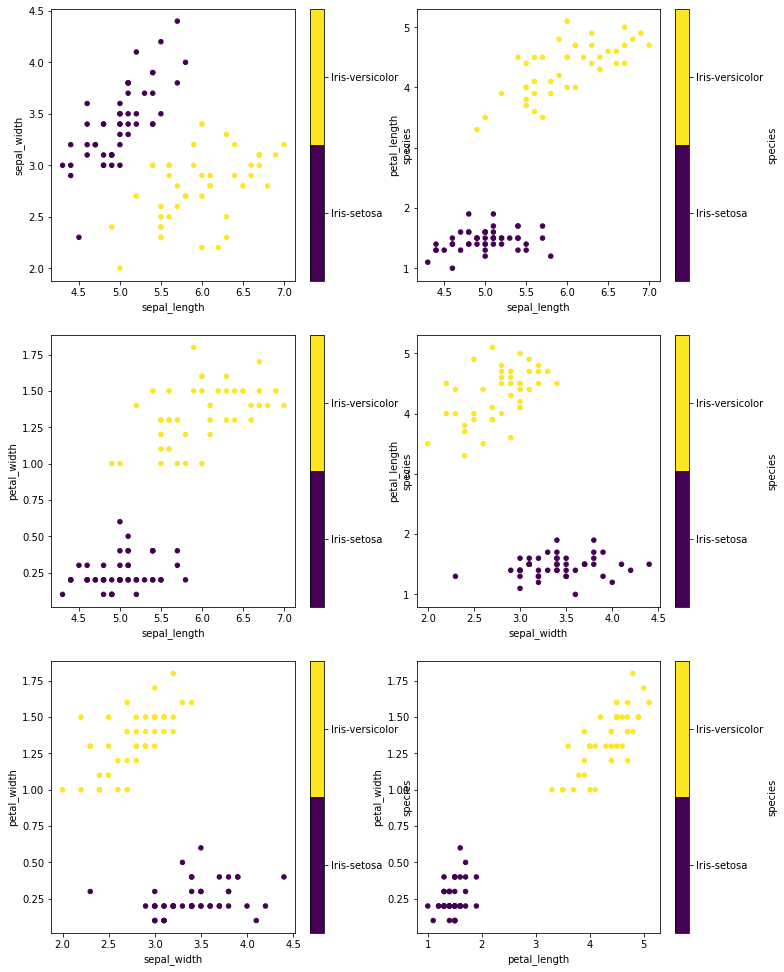

In [16]:
def plots(df):
    """Plots all the combinations of features
      of the set without repetition.

    Args:
        df: original data set
    """
    fig, ax = plt.subplots(3,2, figsize=(12,17))
    indices = [[[0,1,4],[0,2,4]],[[0,3,4],[1,2,4]],[[1,3,4],[2,3,4]]]
    for i, ax_i in enumerate(ax):
        for j, ax_ij in enumerate(ax_i):
            df_aux = df.iloc[:,indices[i][j]]
            df_aux.plot.scatter(df_aux.iloc[:,0].name, df_aux.iloc[:,1].name, c='species', ax=ax_ij, colormap='viridis')                        
    plt.show()
    
plots(df)

Here we are representing each feature of the 90 flowers, in yellow the Iris-versicolor and in purple the Iris-setosa. The information that we can extract from these plots is that the two classes have great separability, so with a good enough hyperplane we are going to get the correct predictions.